In [1]:
import uproot as ur
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['legend.frameon']=True
plt.rcParams['legend.edgecolor']='white'
import uproot,glob,ROOT

from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"] = (10, 8)

import gc

Welcome to JupyROOT 6.28/04


In [2]:
def read_root(filename,treename=None,N=None):
    if type(filename) != str:
        return pd.concat([read_root(f,treename,N) for f in filename])
        
    with ur.open(filename) as f:
        if treename is None:
            if len(f.keys()) == 1:
                treename = f.keys()[0]
            elif len(f.keys()) == 0:
                raise Exception("error: no tree names in file " + filename)
            else:
                raise Exception("error: treename must be specified; more than one tree in " + filename)
            
        df = f[treename].arrays(library="pd")
    return df

In [3]:
dfs={}
#dfs['A']=read_root("root_io/electron_sim_tuples_A.root", "data")
#dfs['D']=read_root("root_io/electron_sim_tuples_D.root", "data")
dfs['A']=read_root("root_io/tuples_A.root", "data")
dfs['D']=read_root("root_io/tuples_D.root", "data")

In [4]:
print(dfs['A'].columns)

Index(['run_num', 'event_num', 'E_beam', 'pid', 'charge', 'status', 'mass',
       'v_x', 'v_y', 'v_z', 'p_x', 'p_y', 'p_z', 'p', 'theta', 'phi', 'beta',
       'trigger_status', 'sector', 'chi2', 'NDF', 'E_PCAL', 'E_ECIN', 'E_ECOU',
       'E_total', 'Delta_TOF', 'Nphe_LTCC', 'Nphe_HTCC', 'Q2', 'nu',
       'x_bjorken', 'y_bjorken', 'W2', 'z_h', 'p_T2', 'p_L2', 'phi_PQ',
       'theta_PQ'],
      dtype='object')


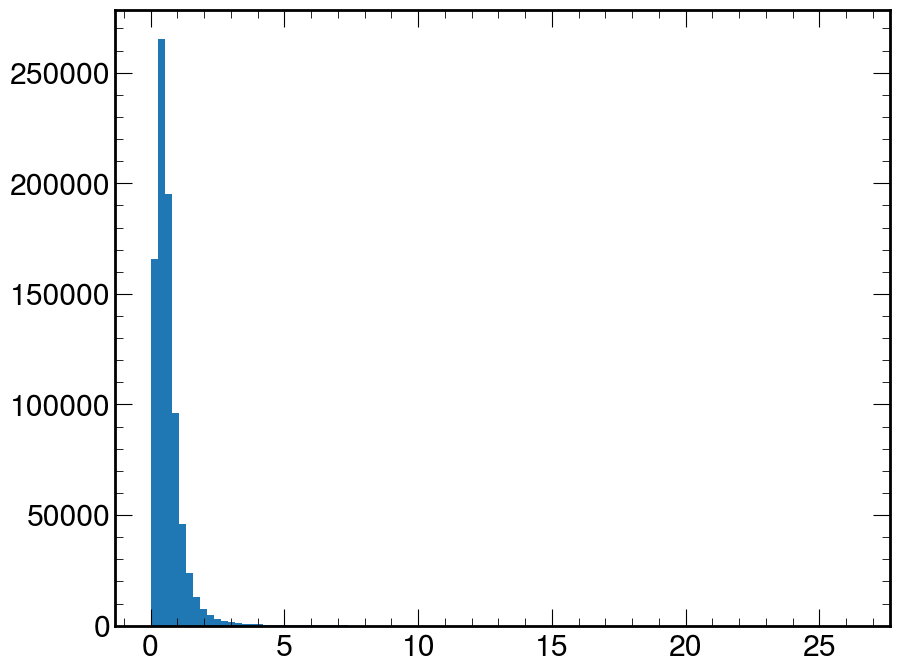

In [5]:
plt.hist(dfs['A'].query("pid==11").eval('(E_ECIN+E_ECOU)/E_PCAL'), bins=100)
#plt.xlabel("$\\Delta T$")
plt.show()

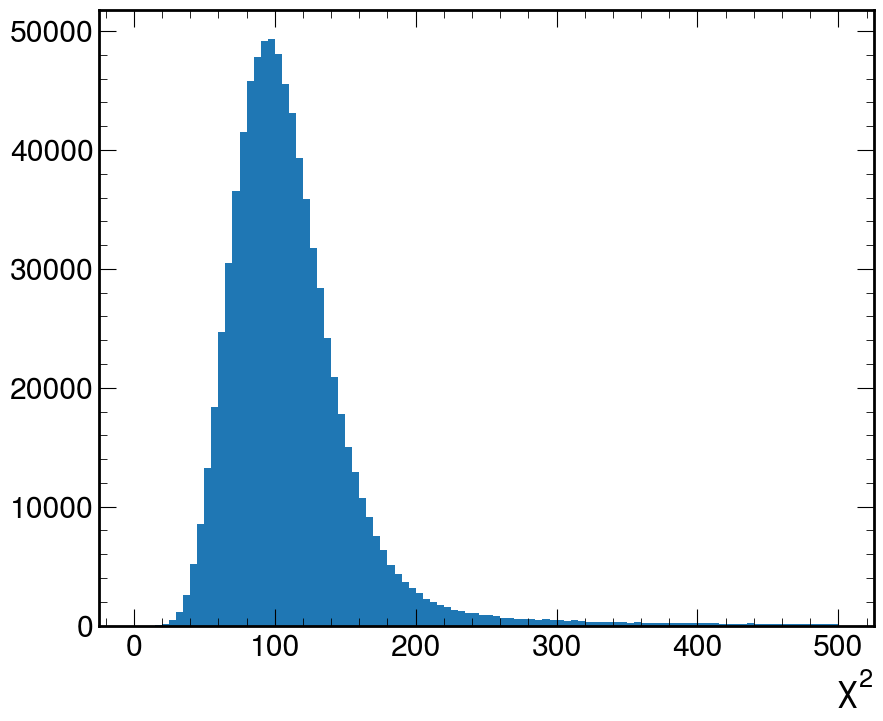

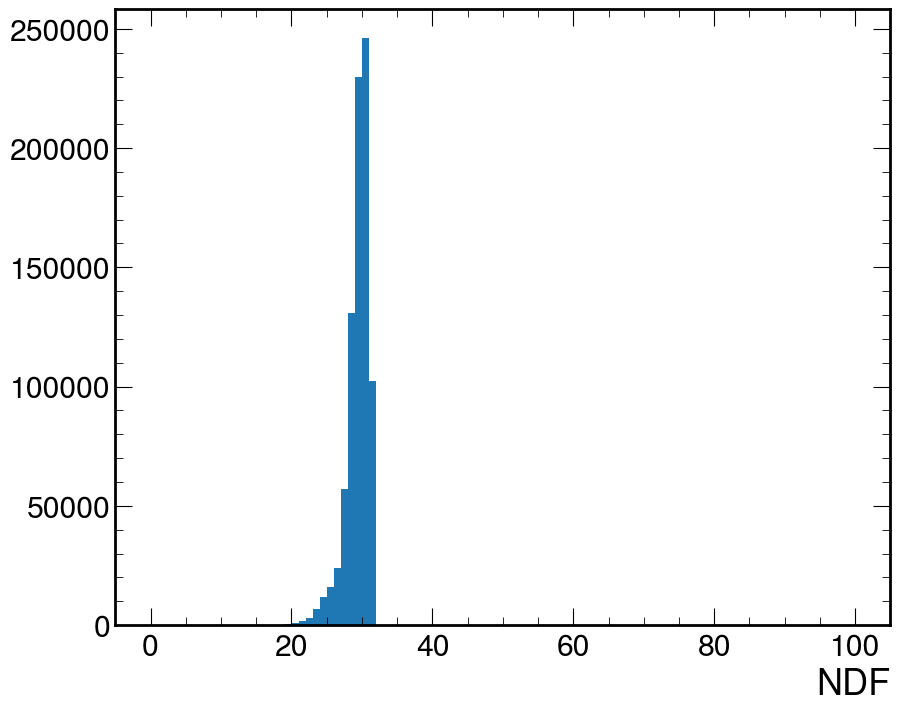

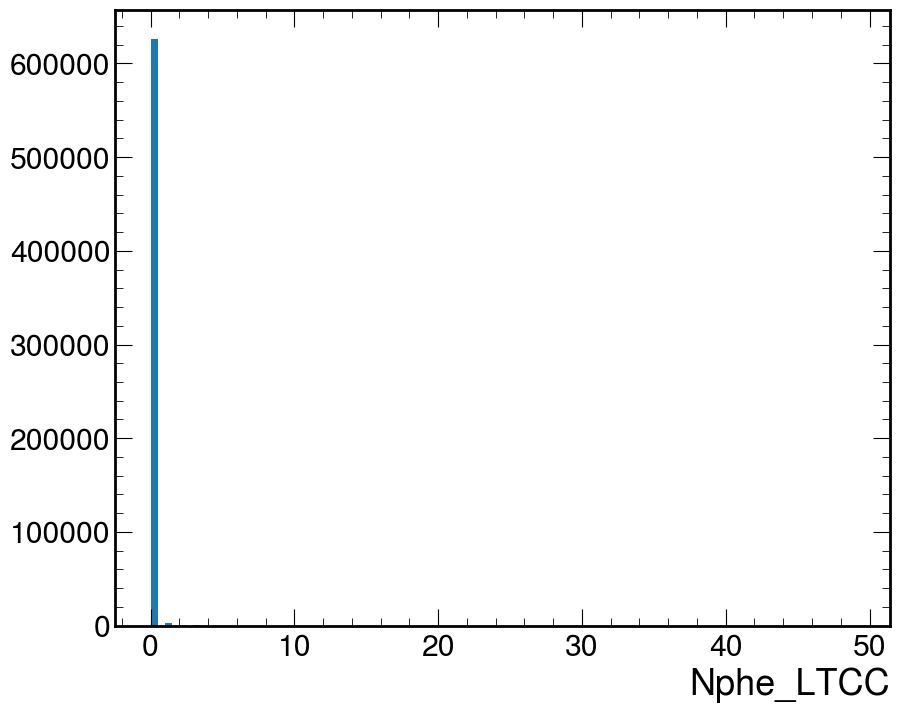

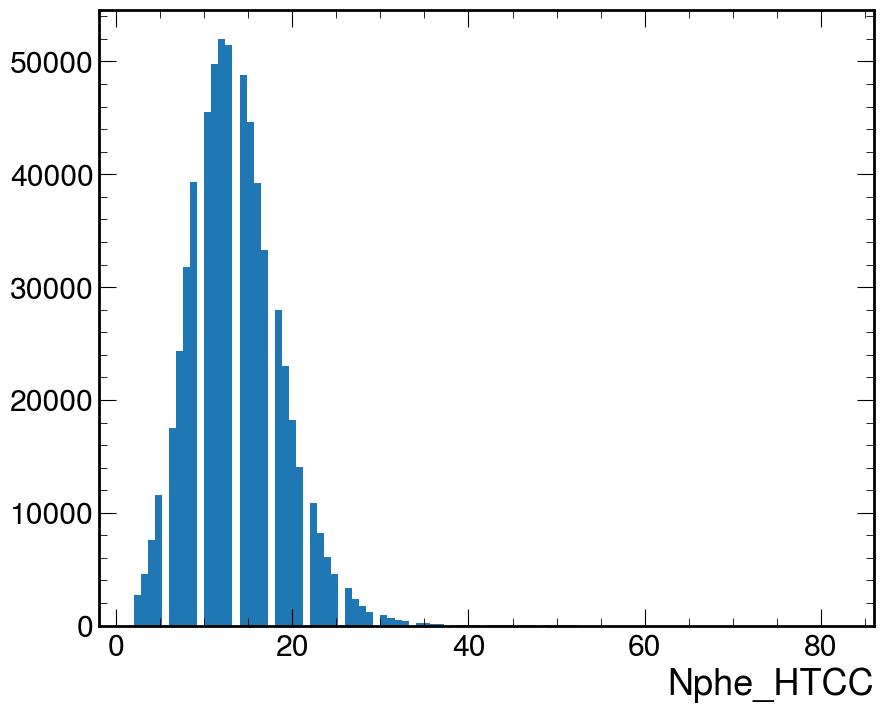

In [6]:
plt.hist(dfs['A'].query("pid==11").chi2, bins=100, range=(0,500))
plt.xlabel("$\\chi^2$")
plt.show()
plt.hist(dfs['A'].query("pid==11").NDF, bins=100, range=(0,100))
plt.xlabel("NDF")
plt.show()
plt.hist(dfs['D'].query("pid==11").Nphe_LTCC, bins=100)
plt.xlabel("Nphe_LTCC")
plt.show()
plt.hist(dfs['D'].query("pid==11").Nphe_HTCC, bins=100)
plt.xlabel("Nphe_HTCC")
plt.show()

In [8]:
#-8.448 to -3.248
#-2.059 to 0.305
#Ryan's cuts, with a shift
vz_A_min=-2.059
vz_A_max=0.305
vz_D_min=-8.448
vz_D_max=-3.248

# offset=2-(vz_A_min+vz_A_max)/2

# vz_A_min+=offset
# vz_A_max+=offset
# vz_D_min+=offset
# vz_D_max+=offset

# #simplified cuts:
# vz_A_min=1
# vz_A_max=3
# vz_D_min=-5
# vz_D_max=-1


print(vz_A_min, vz_A_max)
vertex_cuts=f"((v_z>{vz_A_min} and v_z<{vz_A_max}) or (v_z>{vz_D_min} and v_z<{vz_D_max}))"
print(vertex_cuts)

-2.059 0.305
((v_z>-2.059 and v_z<0.305) or (v_z>-8.448 and v_z<-3.248))


Text(1, 0, 'z [cm]')

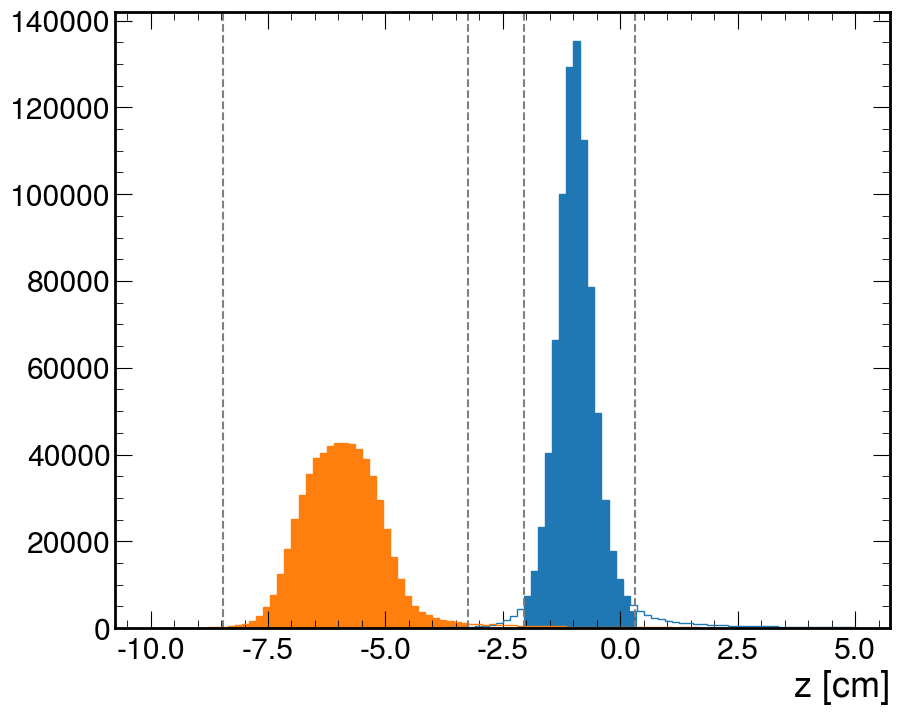

In [9]:
plt.hist(dfs['A']['v_z'], bins=100, range=(-10,5), histtype='step')
plt.hist(dfs['D']['v_z'], bins=100, range=(-10,5), histtype='step')
plt.hist(dfs['A'].query(vertex_cuts)['v_z'], bins=100, range=(-10,5), color='tab:blue')
plt.hist(dfs['D'].query(vertex_cuts)['v_z'], bins=100, range=(-10,5), color='tab:orange')
plt.axvline(vz_A_min, ls='--', color='0.5')
plt.axvline(vz_A_max, ls='--', color='0.5')
plt.axvline(vz_D_min, ls='--', color='0.5')
plt.axvline(vz_D_max, ls='--', color='0.5')
plt.xlabel("z [cm]")

In [10]:
nfilesA=1635
nfilesD=1319
filecountratio=nfilesA/nfilesD
def get_acceptance_ratio(q="Q2<12 and x_bjorken < 1 and x_bjorken>0"):
    nA=len(dfs['A'].query(q))
    nD=len(dfs['D'].query(q))

    if nA!=0 and nD!=0:
        return nA/nD/filecountratio, (nA/nD)*np.sqrt(1/nA+1/nD), nA, nD
    else :
        return 1, 10, 0, 0

In [11]:
print(get_acceptance_ratio())

(1.1123294423786818, 0.002274812139534487, 873942, 633835)


/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_62607/1529713933.py:33: RuntimeWarning: divide by zero encountered in divide
  h = hists['A'][0] / hists['D'][0]/filecountratio
/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_62607/1529713933.py:33: RuntimeWarning: invalid value encountered in divide
  h = hists['A'][0] / hists['D'][0]/filecountratio


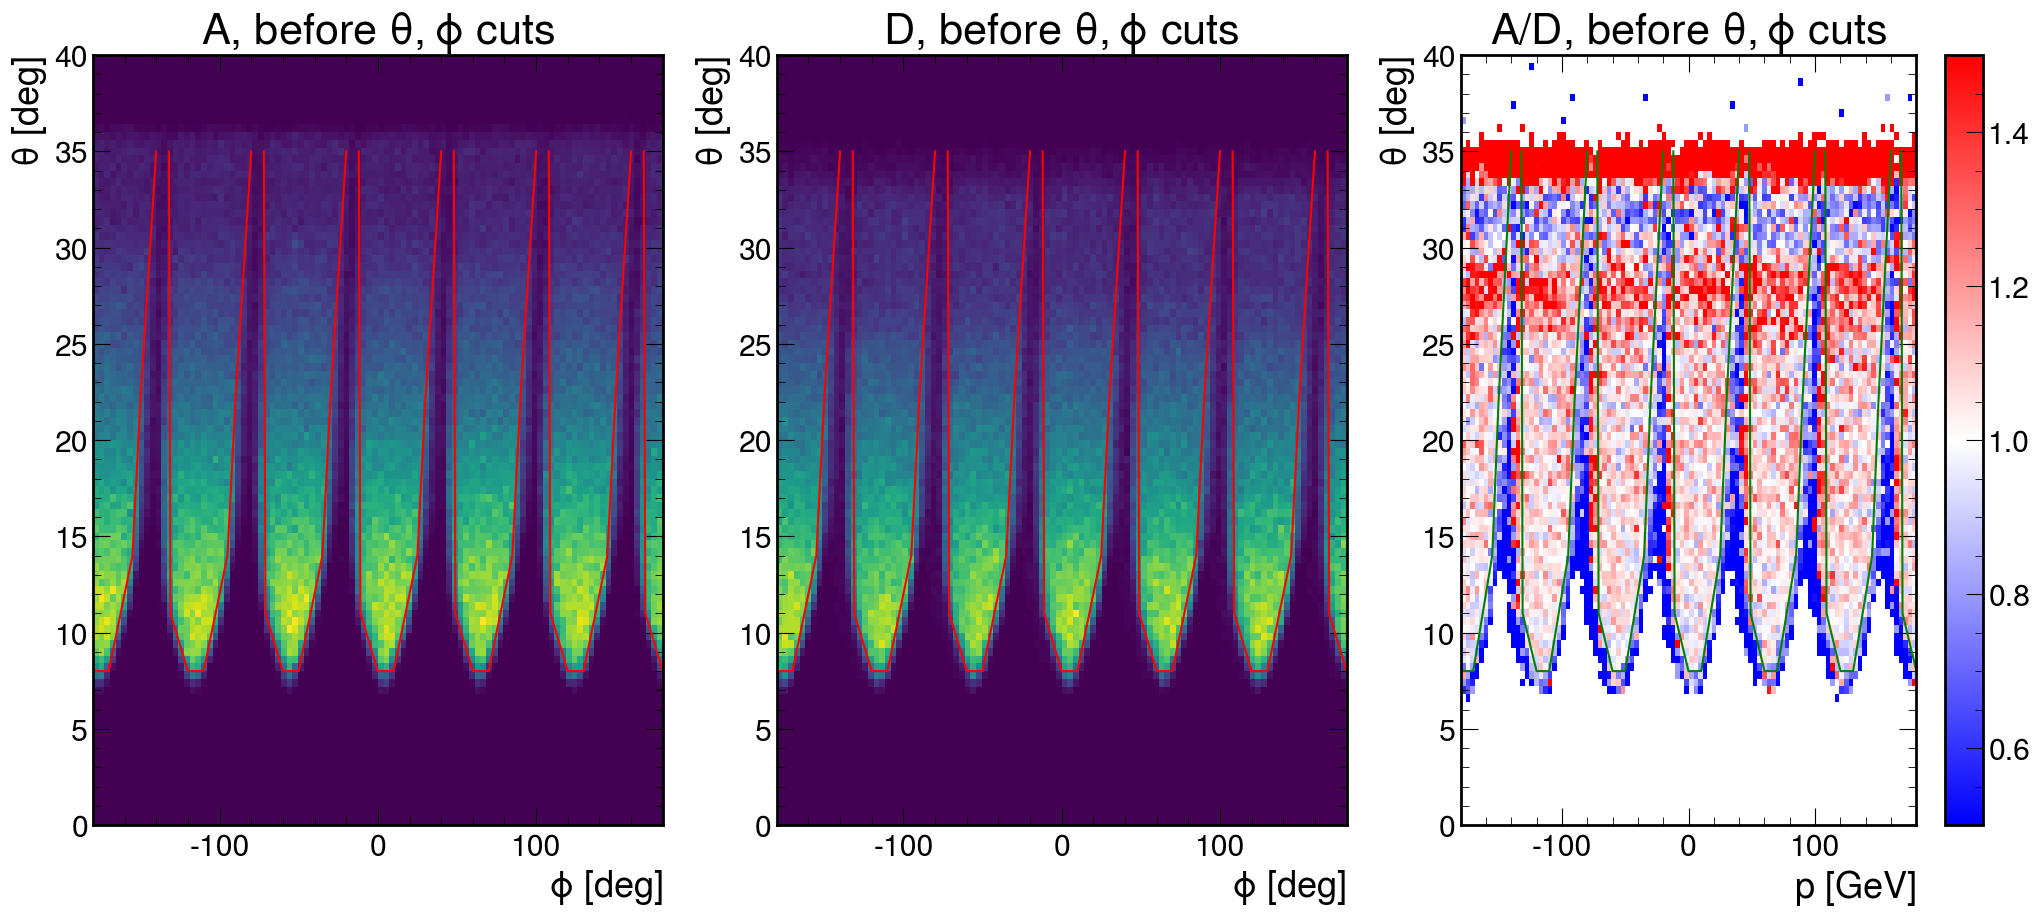

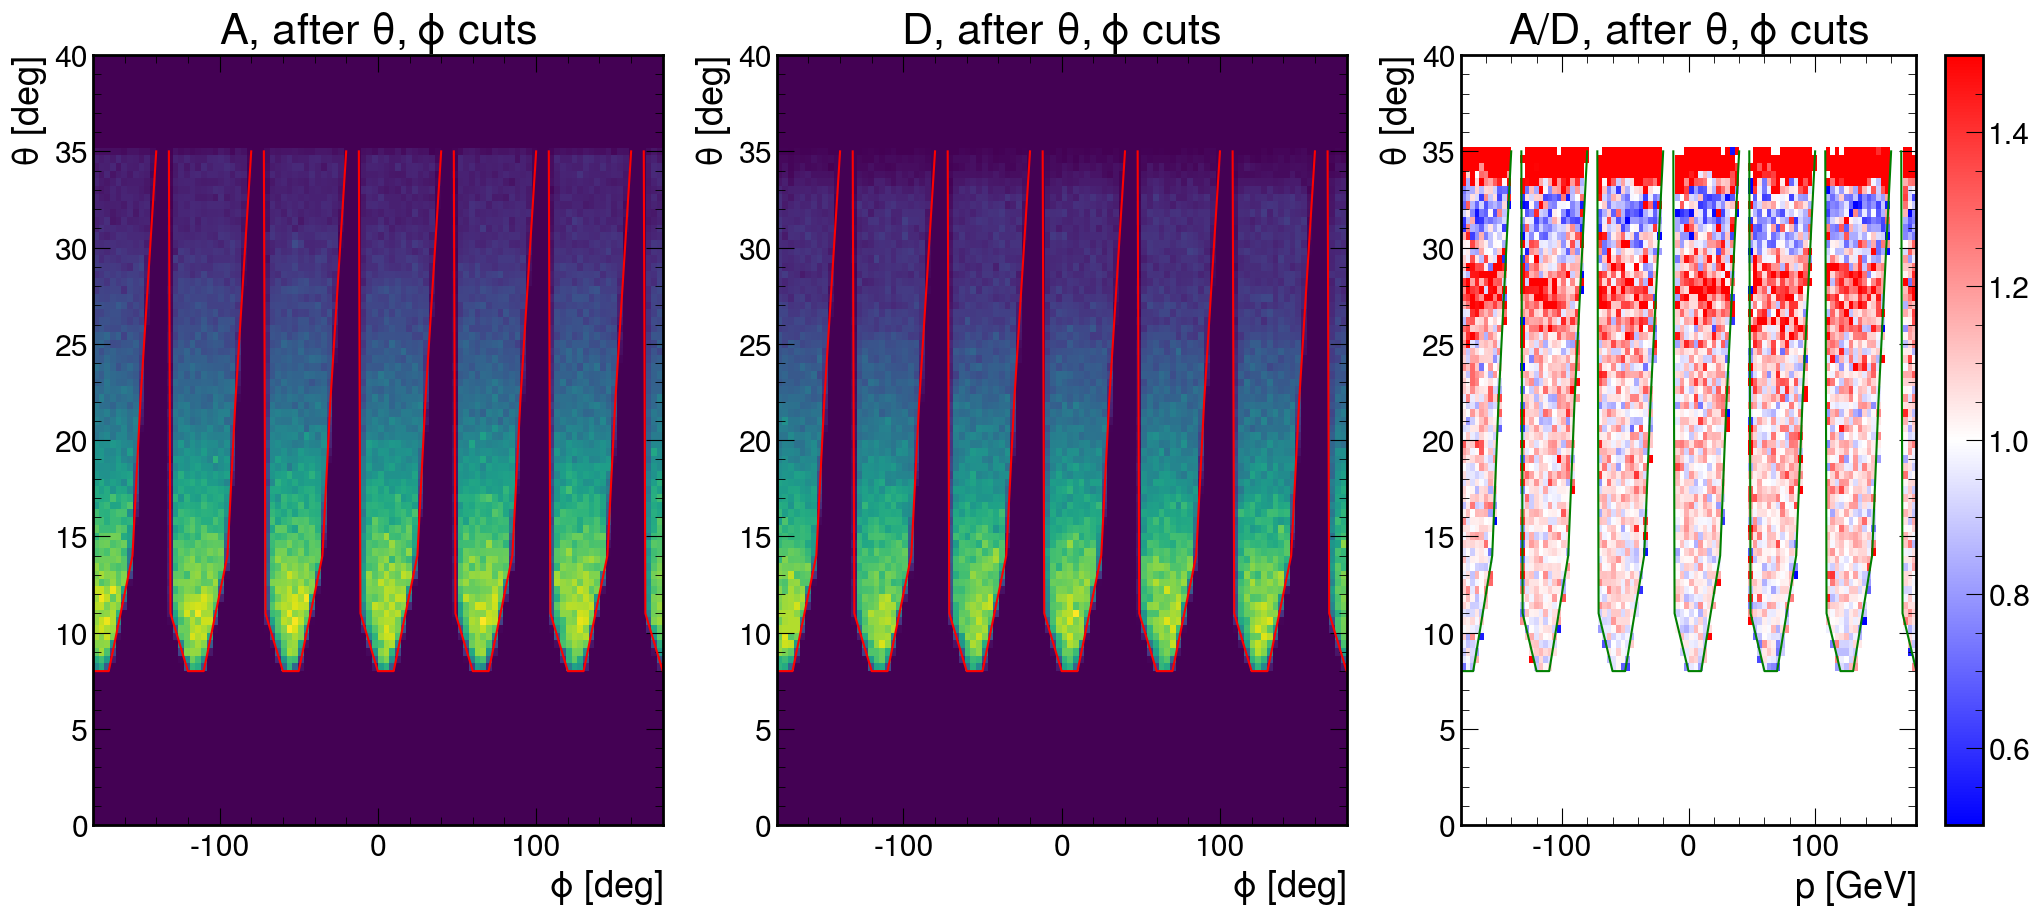

In [28]:
fid_cuts_phi=np.array([-12, -11, 0, 10, 20,25, 30,40])
fid_cuts_theta=np.array([35, 11, 8,8,12,14, 22,35])

fid_cuts=""
phip=f"(phi*{180/np.pi}+180+10)%60-10"
for i in range(len(fid_cuts_phi)-1):
    fid_cuts+=f" and theta*{180/np.pi}>{fid_cuts_theta[i]}+({phip}-{fid_cuts_phi[i]})/({fid_cuts_phi[i+1]-fid_cuts_phi[i]})*({fid_cuts_theta[i+1]-fid_cuts_theta[i]})"
fid_cuts="("+fid_cuts[5:]+f" and theta*{180/np.pi}<{fid_cuts_theta[0]})"

q="W2>2**2 and y_bjorken<0.85"
q+="and pid==11 and trigger_status==1"
q+=" and " + vertex_cuts



for useFidCuts in False, True:
    hists={}
    fig, axs = plt.subplots(1,3, figsize=(25,10))
    for ax, tar in zip(axs,"AD"):
        plt.sca(ax)
        dfq=dfs[tar].query(q)

        hists[tar]=plt.hist2d(dfq.phi*180/np.pi, dfq.theta*180/np.pi, bins=100, range=((-180, 180), (0, 40)))
        for i in range(-3, 4):
            plt.plot(fid_cuts_phi+60*i, fid_cuts_theta, color='r')  
        plt.xlabel("$\\phi$ [deg]")
        plt.ylabel("$\\theta$ [deg]")  
        plt.title(tar + (", before $\\theta,\\phi$ cuts" if not useFidCuts else ", after $\\theta,\\phi$ cuts"))
    
    
    #create ratio plot
    plt.sca(axs[2])
    h = hists['A'][0] / hists['D'][0]/filecountratio
    xedges,yedges= hists['A'][1:3]
    import matplotlib
    #help(plt.gca().pcolorfast)
    from matplotlib import colormaps
    pc = plt.gca().pcolorfast(xedges, yedges, h.T, norm=matplotlib.colors.Normalize(0.5, 1.5), cmap=colormaps['bwr'])
    plt.xlabel("$p$ [GeV]")
    plt.ylabel("$\\theta$ [deg]")  
    plt.title("A/D"+ (", before $\\theta,\\phi$ cuts" if not useFidCuts else ", after $\\theta,\\phi$ cuts"))
    plt.xlim(-180,180)
    for i in range(-3, 4):
        plt.plot(fid_cuts_phi+60*i, fid_cuts_theta, color='g')  
    plt.colorbar(pc)
    plt.show()
        
    q+=" and " + fid_cuts



/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_62607/2538001194.py:32: RuntimeWarning: divide by zero encountered in divide
  h = hists['A'][0] / hists['D'][0]/filecountratio
/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_62607/2538001194.py:32: RuntimeWarning: invalid value encountered in divide
  h = hists['A'][0] / hists['D'][0]/filecountratio


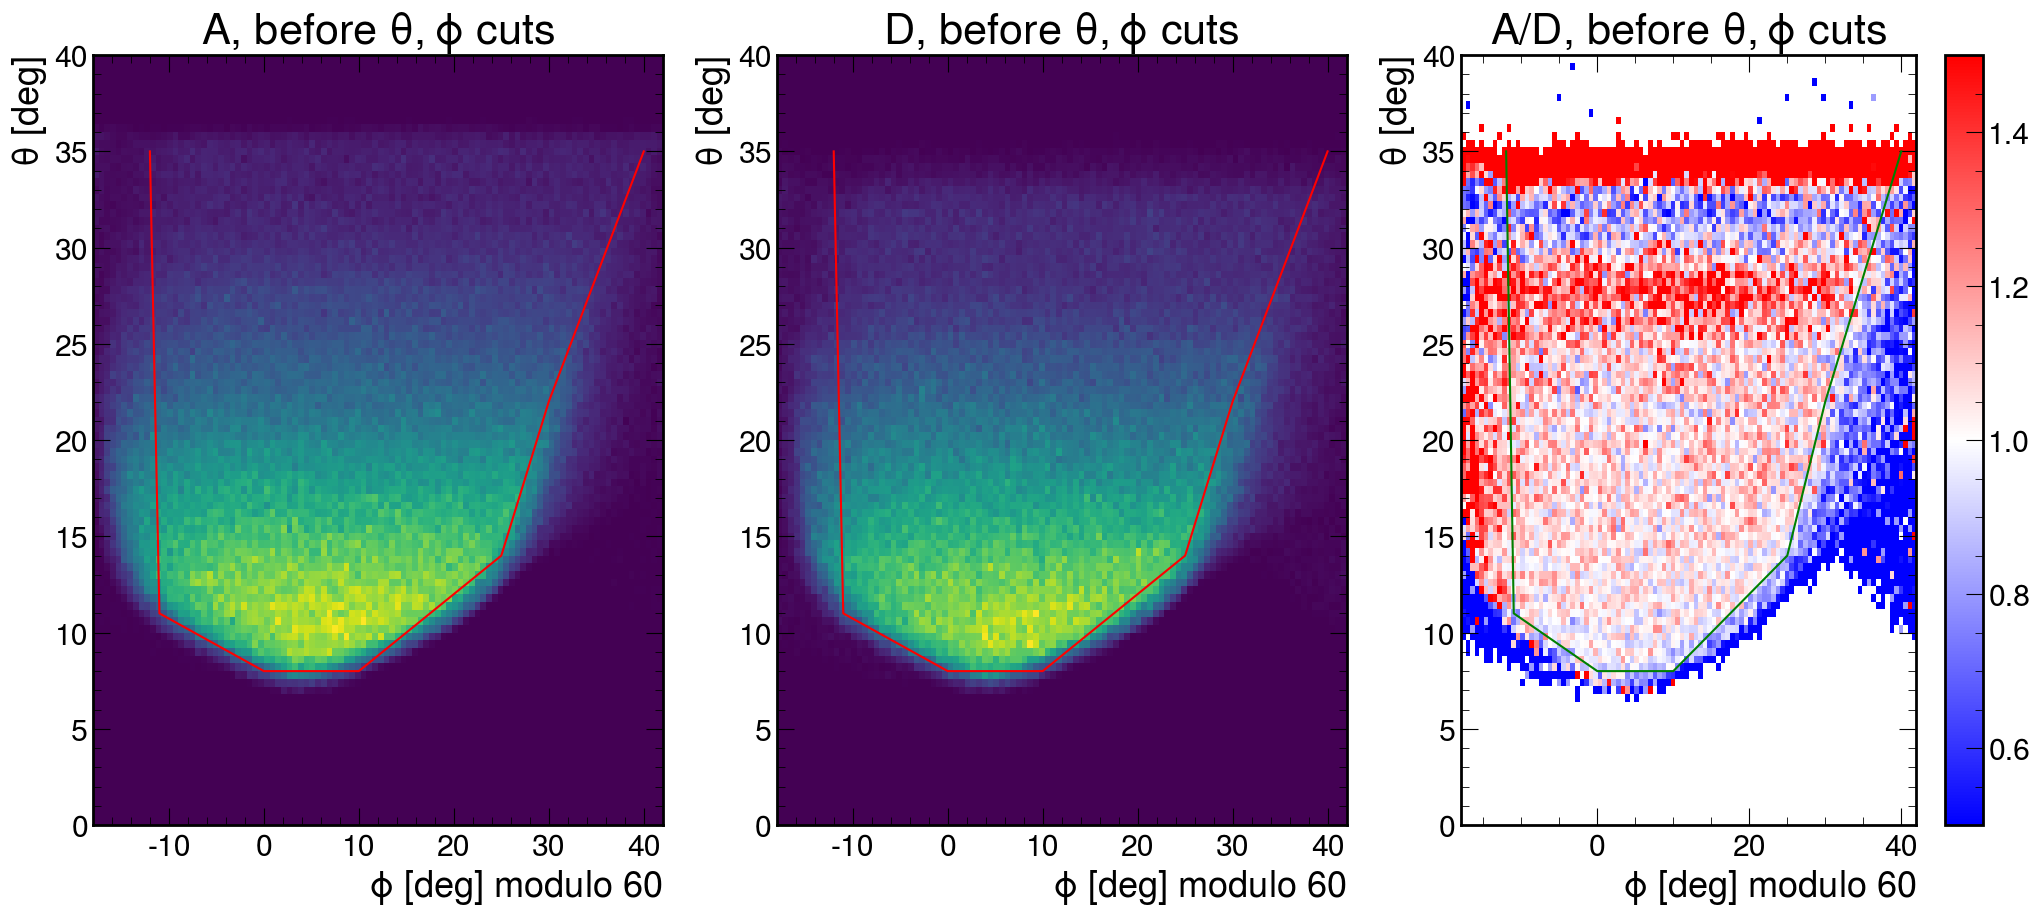

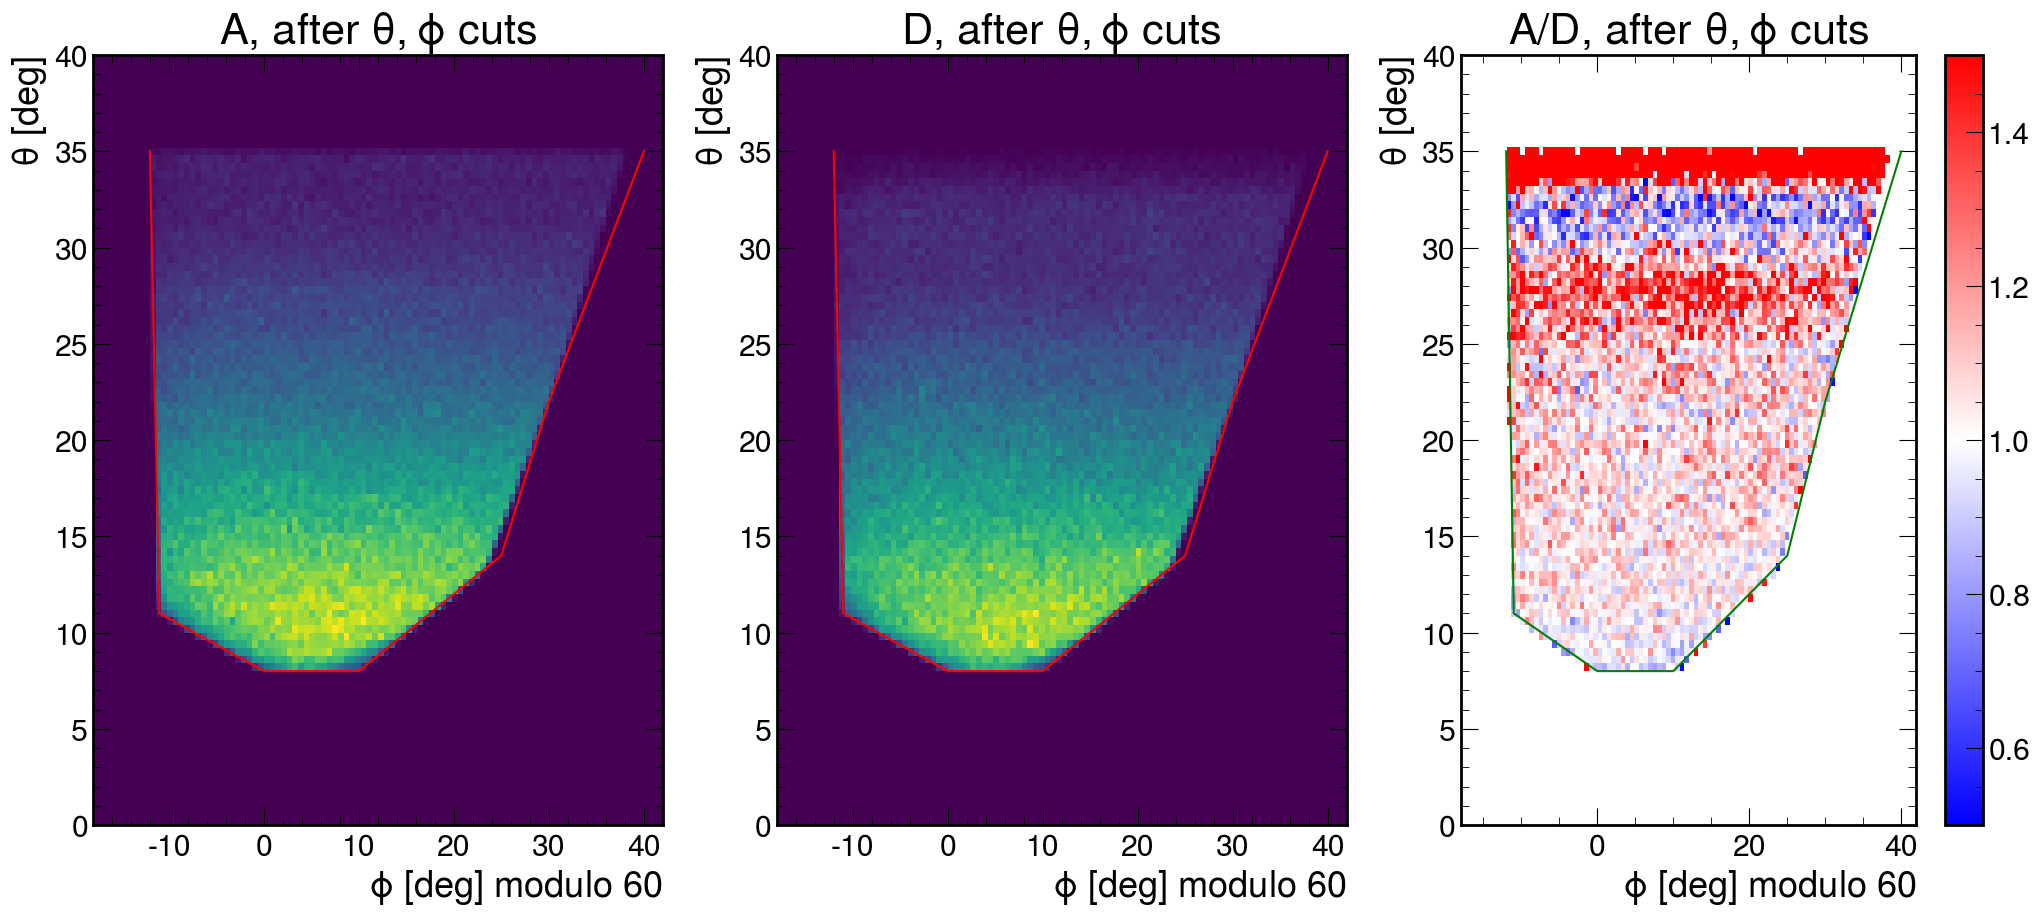

In [29]:
fid_cuts_phi=np.array([-12, -11, 0, 10, 20,25, 30,40])
fid_cuts_theta=np.array([35, 11, 8,8,12,14, 22,35])

fid_cuts=""
phip=f"(phi*{180/np.pi}+180+18)%60-18"
for i in range(len(fid_cuts_phi)-1):
    fid_cuts+=f" and theta*{180/np.pi}>{fid_cuts_theta[i]}+({phip}-{fid_cuts_phi[i]})/({fid_cuts_phi[i+1]-fid_cuts_phi[i]})*({fid_cuts_theta[i+1]-fid_cuts_theta[i]})"
fid_cuts="("+fid_cuts[5:]+f" and theta*{180/np.pi}<{fid_cuts_theta[0]})"

q="W2>2**2 and y_bjorken<0.85"
q+="and pid==11 and trigger_status==1"
q+=" and " + vertex_cuts



for useFidCuts in False, True:
    hists={}
    fig, axs = plt.subplots(1,3, figsize=(25,10))
    for ax, tar in zip(axs,"AD"):
        plt.sca(ax)
        dfq=dfs[tar].query(q)

        hists[tar]=plt.hist2d(((dfq.phi*180/np.pi+18)%60)-18, dfq.theta*180/np.pi, bins=100, range=((-18, 42), (0, 40)))
        plt.plot(fid_cuts_phi, fid_cuts_theta, color='r')  
        plt.xlabel("$\\phi$ [deg] modulo 60")
        plt.ylabel("$\\theta$ [deg]")  
        plt.title(tar + (", before $\\theta,\\phi$ cuts" if not useFidCuts else ", after $\\theta,\\phi$ cuts"))
    
    
    #create ratio plot
    plt.sca(axs[2])
    h = hists['A'][0] / hists['D'][0]/filecountratio
    xedges,yedges= hists['A'][1:3]
    import matplotlib
    #help(plt.gca().pcolorfast)
    from matplotlib import colormaps
    pc = plt.gca().pcolorfast(xedges, yedges, h.T, norm=matplotlib.colors.Normalize(0.5, 1.5), cmap=colormaps['bwr'])
    plt.xlabel("$\\phi$ [deg] modulo 60")
    plt.ylabel("$\\theta$ [deg]")  
    plt.title("A/D"+ (", before $\\theta,\\phi$ cuts" if not useFidCuts else ", after $\\theta,\\phi$ cuts"))
    plt.plot(fid_cuts_phi, fid_cuts_theta, color='g')  
    plt.colorbar(pc)
    plt.show()
        
    q+=" and " + fid_cuts

/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_62607/1473265690.py:26: RuntimeWarning: divide by zero encountered in divide
  h = hists['A'][0] / hists['D'][0]/filecountratio
/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_62607/1473265690.py:26: RuntimeWarning: invalid value encountered in divide
  h = hists['A'][0] / hists['D'][0]/filecountratio


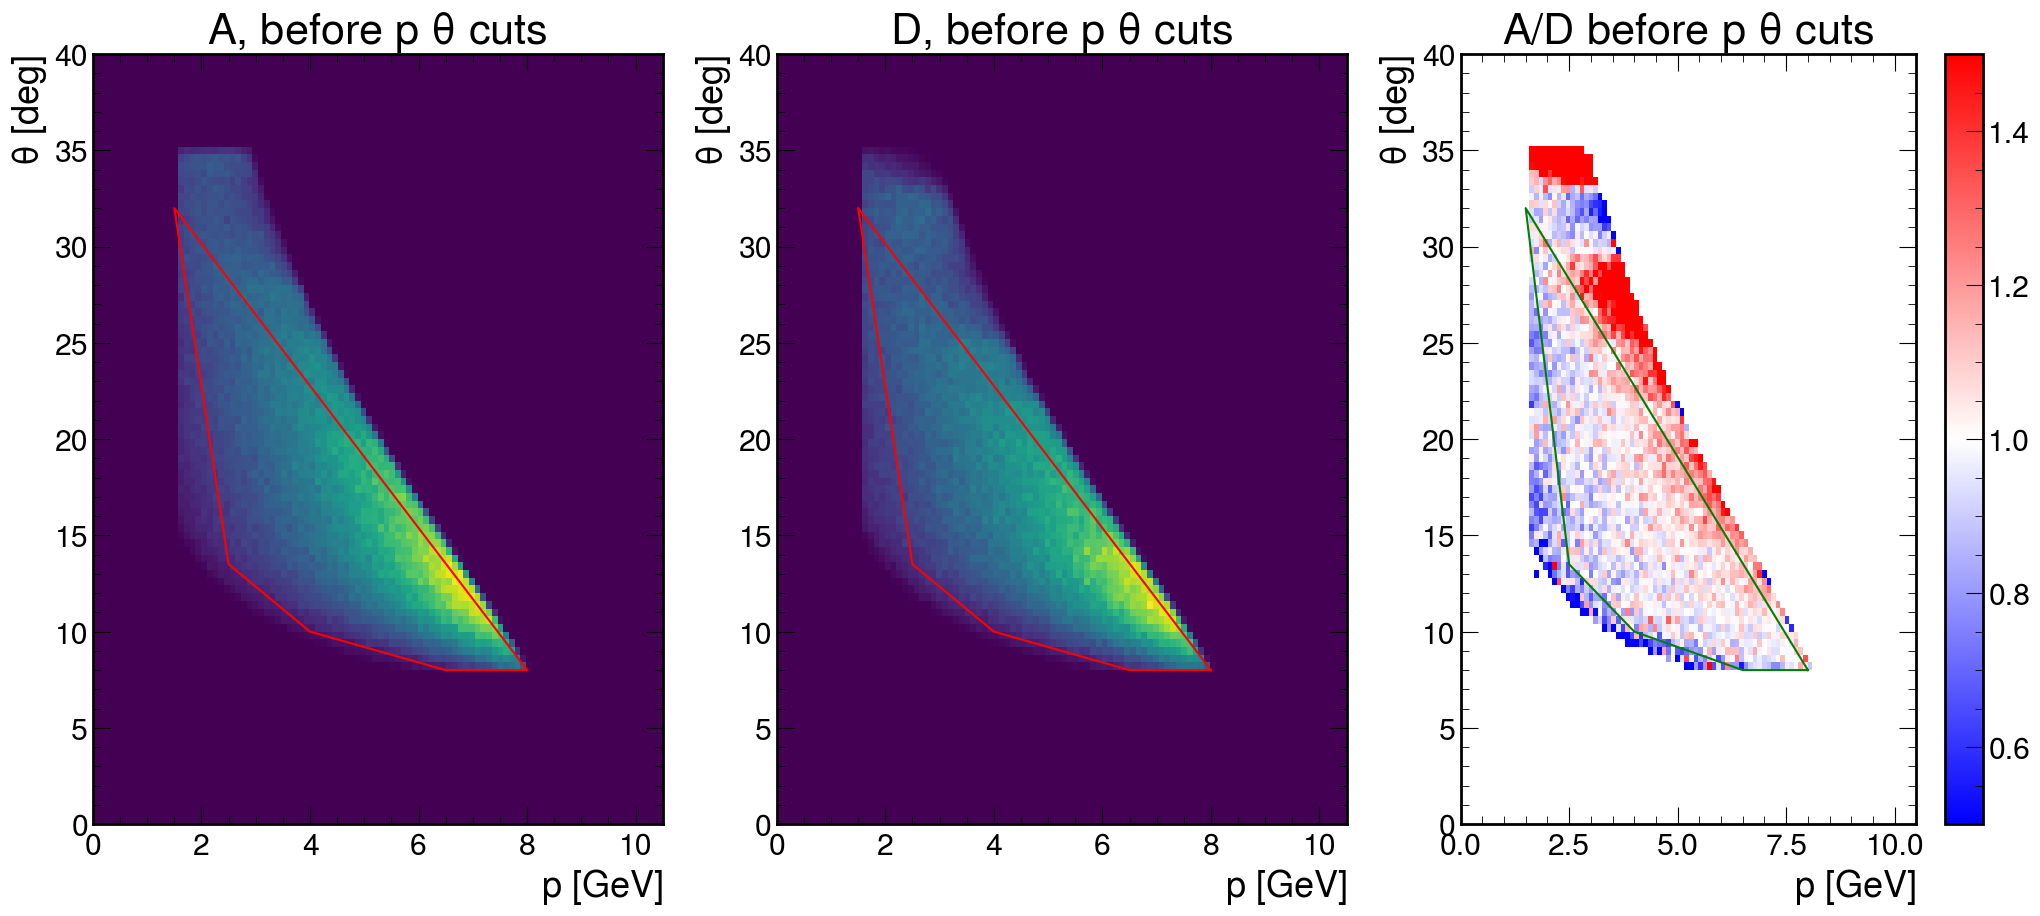

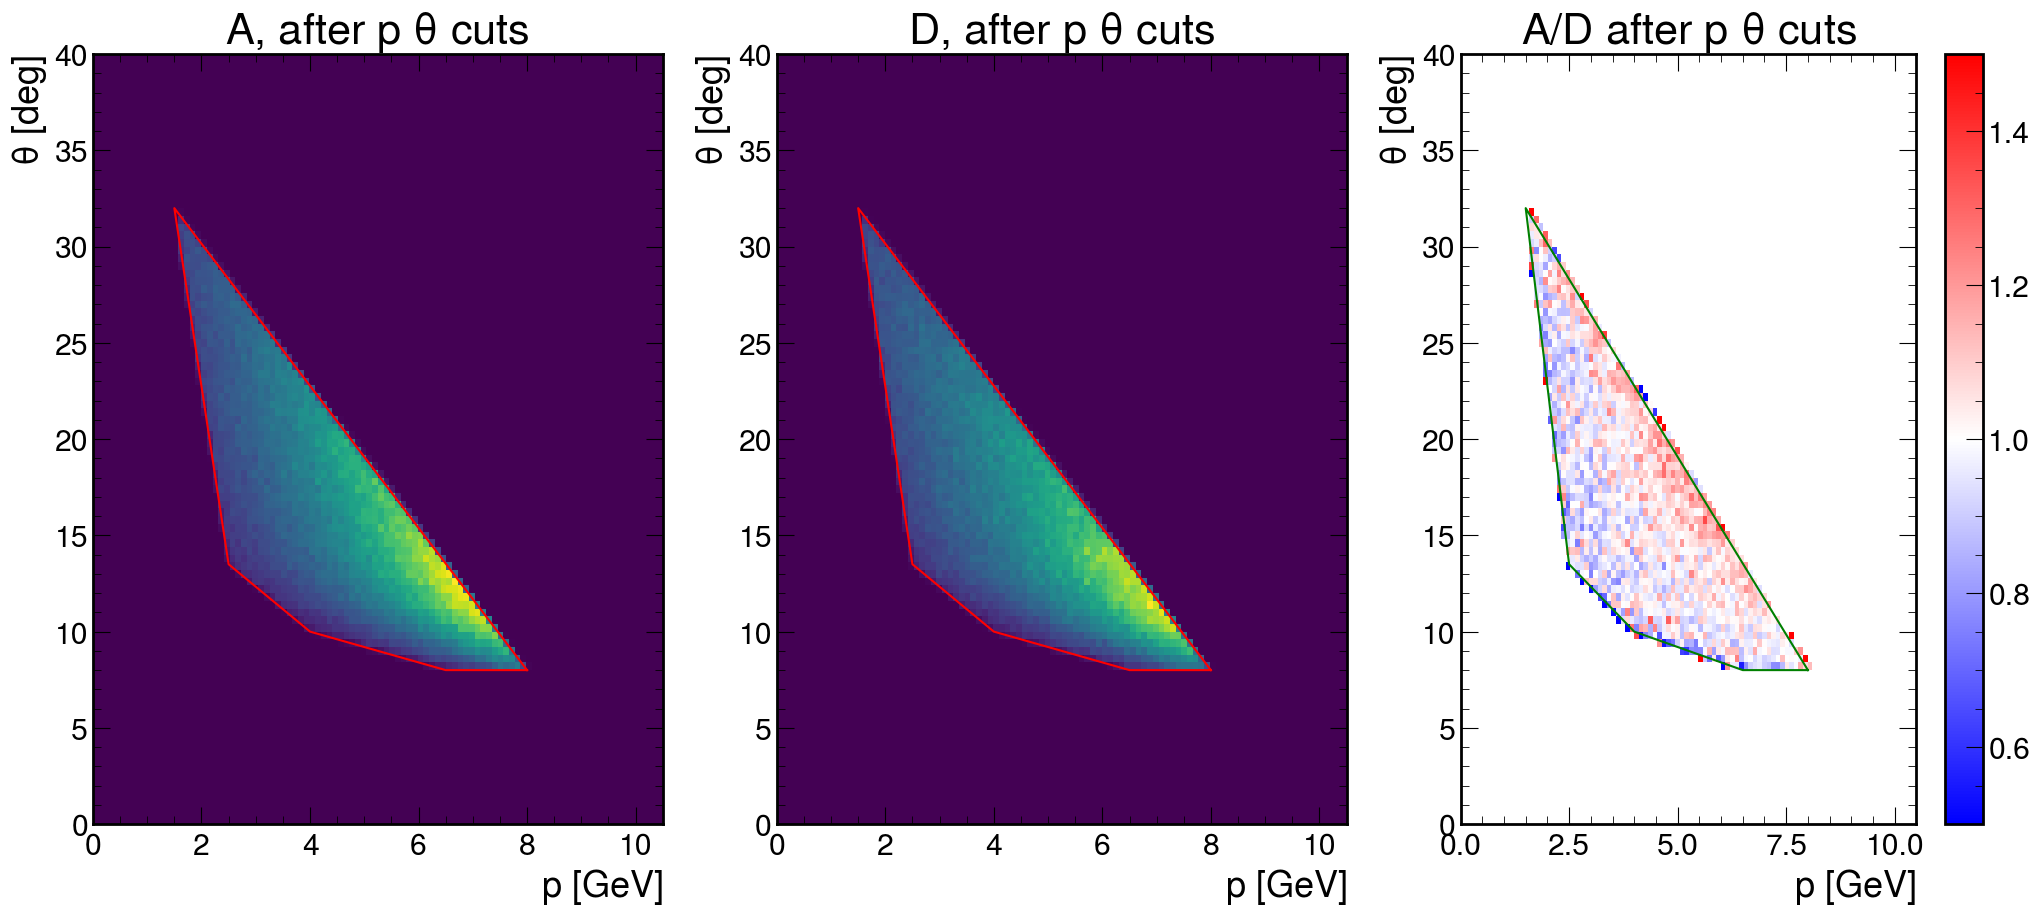

In [30]:
q="W2>2**2 and y_bjorken<0.85"
q+="and pid==11 and trigger_status==1"
q+=" and " + vertex_cuts
q+=" and " + fid_cuts

kin_cuts_p=[8, 6.5, 4, 2.5, 1.5, 8]
kin_cuts_theta=[8,8,10, 13.5,32, 8]


for useKinCuts in False, True:
    
    fig, axs = plt.subplots(1,3, figsize=(25,10))
    hists={}
    for ax, tar in zip(axs,"AD"):
        plt.sca(ax)
        dfq=dfs[tar].query(q)

        hists[tar]=plt.hist2d(dfq.p, dfq.theta*180/np.pi, bins=100, range=((0, 10.5), (0, 40)))
        plt.plot(kin_cuts_p, kin_cuts_theta, color='r')
        plt.xlabel("$p$ [GeV]")
        plt.ylabel("$\\theta$ [deg]")  
        plt.title(tar + (", before p $\\theta$ cuts" if not useKinCuts else ", after p $\\theta$ cuts"))
    plt.sca(axs[2])

    #create ratio plot
    h = hists['A'][0] / hists['D'][0]/filecountratio
    xedges,yedges= hists['A'][1:3]
    import matplotlib
    #help(plt.gca().pcolorfast)
    from matplotlib import colormaps
    pc = plt.gca().pcolorfast(xedges, yedges, h.T, norm=matplotlib.colors.Normalize(0.5, 1.5), cmap=colormaps['bwr'])
    plt.xlabel("$p$ [GeV]")
    plt.ylabel("$\\theta$ [deg]")  
    plt.title("A/D" + (" after " if useKinCuts else " before ") + "p $\\theta$ cuts")
    plt.plot(kin_cuts_p, kin_cuts_theta, color='g')
    plt.colorbar(pc)
    plt.show()
    kin_cuts=""
    for i in range(len(kin_cuts_p)-1):
        kin_cuts+=f" and ({kin_cuts_p[i+1]-kin_cuts_p[i]})*(theta*{180/np.pi}-{kin_cuts_theta[i]})<+(p-{kin_cuts_p[i]})*({kin_cuts_theta[i+1]-kin_cuts_theta[i]})"
    kin_cuts = kin_cuts[5:]
    q+= " and " +kin_cuts
    


/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_62607/4217912350.py:21: RuntimeWarning: divide by zero encountered in divide
  h = hists['A'][0] / hists['D'][0]/filecountratio
/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_62607/4217912350.py:21: RuntimeWarning: invalid value encountered in divide
  h = hists['A'][0] / hists['D'][0]/filecountratio


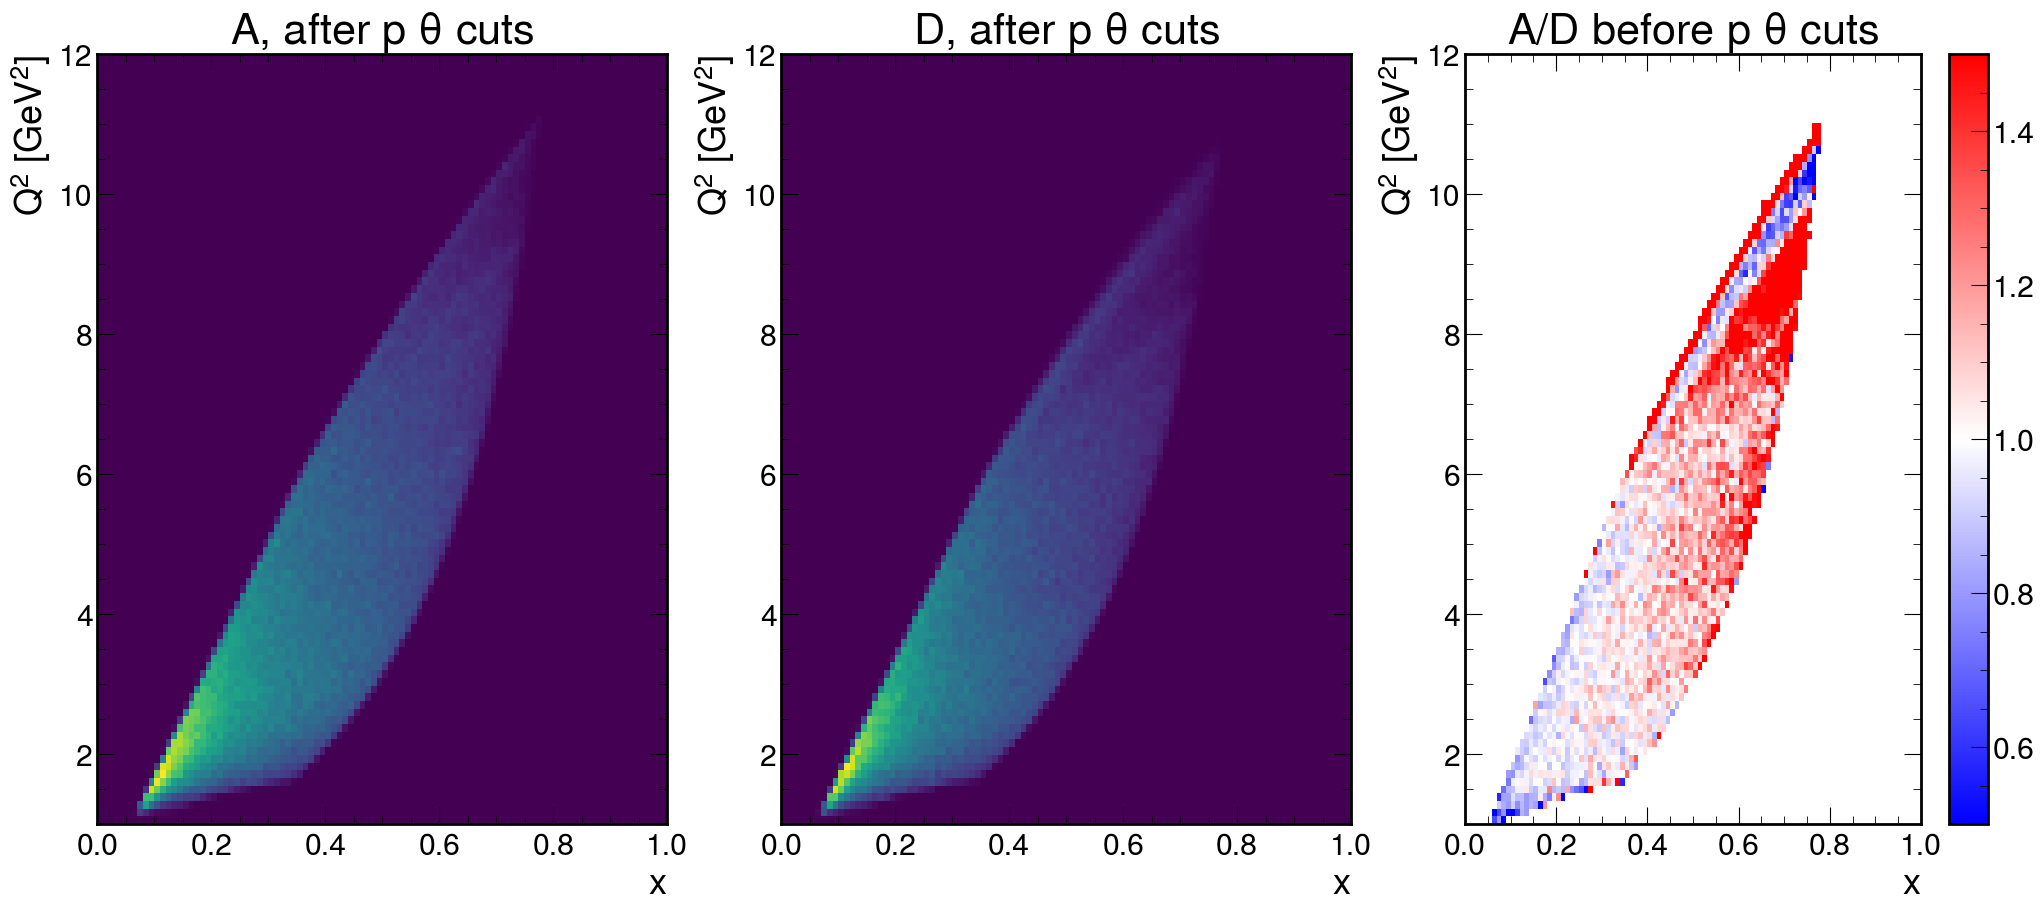

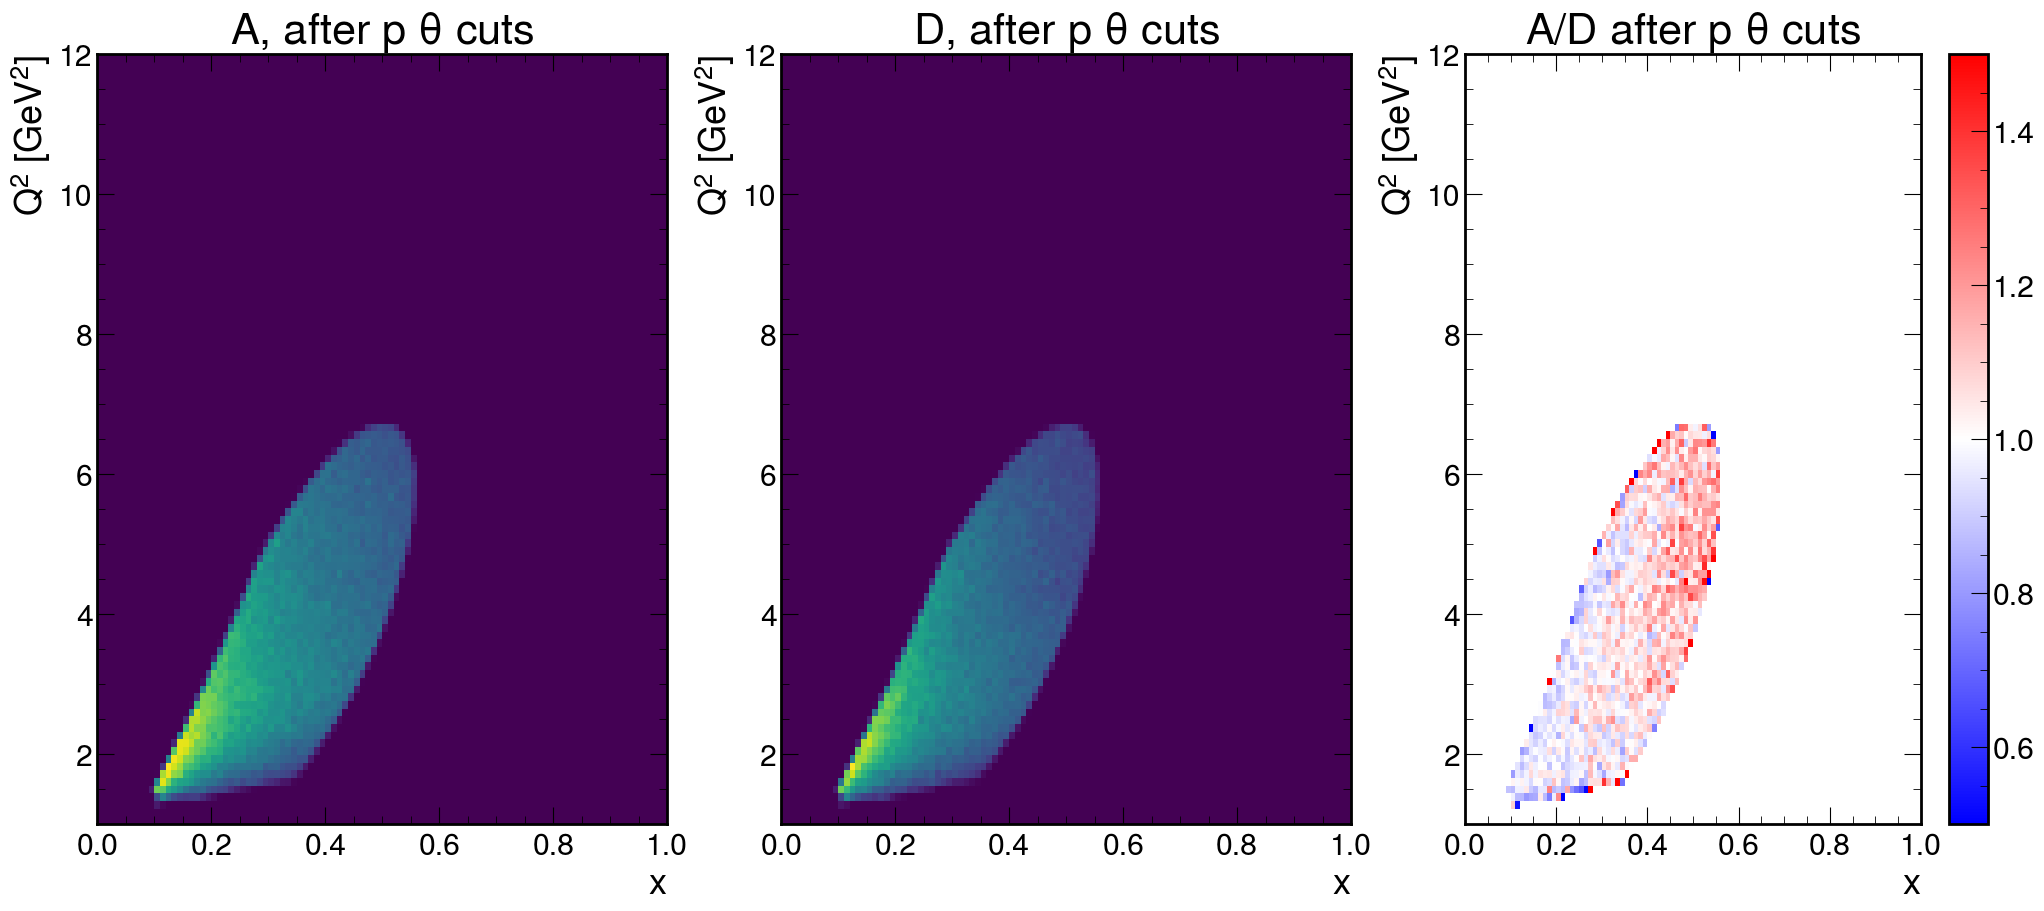

In [15]:
q="W2>2**2 and y_bjorken<0.85"
q+="and pid==11 and trigger_status==1"
q+=" and " + vertex_cuts
q+=" and " + fid_cuts

for useKinCuts in False, True:
    
    fig, axs = plt.subplots(1,3, figsize=(25,10))
    hists={}
    for ax, tar in zip(axs,"AD"):
        plt.sca(ax)
        dfq=dfs[tar].query(q)

        hists[tar]=plt.hist2d(dfq.x_bjorken, dfq.Q2, bins=100, range=((0, 1),(1,12)))
        plt.xlabel("$x$")
        plt.ylabel("$Q^2$ [GeV$^2$]")   
        plt.title(tar + (", before p $\\theta$ cuts" if not useFidCuts else ", after p $\\theta$ cuts"))
    plt.sca(axs[2])

    #create ratio plot
    h = hists['A'][0] / hists['D'][0]/filecountratio
    xedges,yedges= hists['A'][1:3]
    import matplotlib
    #help(plt.gca().pcolorfast)
    from matplotlib import colormaps
    pc = plt.gca().pcolorfast(xedges, yedges, h.T, norm=matplotlib.colors.Normalize(0.5, 1.5), cmap=colormaps['bwr'])
    plt.xlabel("$x$")
    plt.ylabel("$Q^2$ [GeV$^2$]")  
    plt.title("A/D" + (" after " if useKinCuts else " before ") + "p $\\theta$ cuts")
    #plt.plot(kin_cuts_p, kin_cuts_theta, color='g')
    plt.colorbar(pc)
    plt.show()
    kin_cuts=""
    for i in range(len(kin_cuts_p)-1):
        kin_cuts+=f" and ({kin_cuts_p[i+1]-kin_cuts_p[i]})*(theta*{180/np.pi}-{kin_cuts_theta[i]})<+(p-{kin_cuts_p[i]})*({kin_cuts_theta[i+1]-kin_cuts_theta[i]})"
    kin_cuts = kin_cuts[5:]
    q+= " and " +kin_cuts

(1.0, 6.711405277252197)

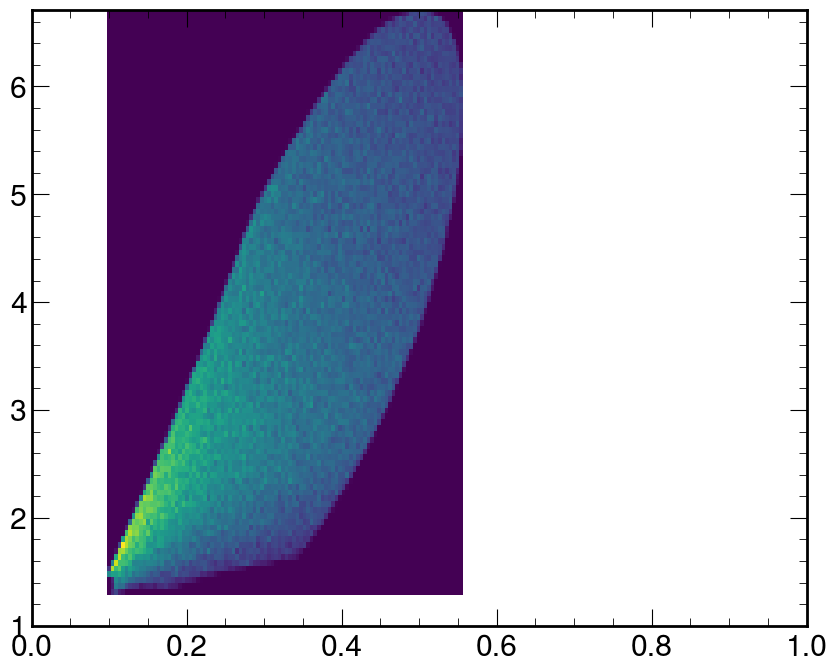

In [16]:
q="W2>2**2 and y_bjorken<0.85"
q+="and pid==11 and trigger_status==1"
q+= " and "+fid_cuts+ " and " +vertex_cuts +" and " + kin_cuts
dfq=dfs['A'].query(q)
plt.hist2d(dfq.x_bjorken, dfq.Q2, bins=100)
plt.xlim(0,1)
plt.ylim(1)

In [17]:
#Q2bins=np.geomspace(1,12, 10)
#xbins=np.linspace(0.05,0.8, 6)

xbins=[0.06060606, 0.09646465, 0.13232323, 0.16818182, 0.2040404,  0.23989899,
      0.27575758, 0.31161616, 0.34747475, 0.38333333, 0.41919192, 0.45505051,
      0.49090909, 0.52676768, 0.56262626, 0.59848485, 0.63434343, 0.67020202,
      0.70606061, 0.74191919, 0.77777778]
Q2bins=[1.01958322, 1.32860611, 1.73128997, 2.25602227, 2.93979434, 3.83080915,
      4.99187939, 6.50485546,  8.47639562, 11.04548489]

In [18]:
include_bin= {(0, 0): True, (0, 1): False, (0, 2): False, (0, 3): False, (0, 4): False, (0, 5): False, (0, 6): False, (0, 7): False, (0, 8): False, (1, 0): True, (1, 1): True, (1, 2): True, (1, 3): False, (1, 4): False, (1, 5): False, (1, 6): False, (1, 7): False, (1, 8): False, (2, 0): True, (2, 1): True, (2, 2): True, (2, 3): True, (2, 4): False, (2, 5): False, (2, 6): False, (2, 7): False, (2, 8): False, (3, 0): True, (3, 1): True, (3, 2): True, (3, 3): True, (3, 4): False, (3, 5): False, (3, 6): False, (3, 7): False, (3, 8): False, (4, 0): True, (4, 1): True, (4, 2): True, (4, 3): True, (4, 4): True, (4, 5): False, (4, 6): False, (4, 7): False, (4, 8): False, (5, 0): True, (5, 1): True, (5, 2): True, (5, 3): True, (5, 4): True, (5, 5): True, (5, 6): False, (5, 7): False, (5, 8): False, (6, 0): False, (6, 1): True, (6, 2): True, (6, 3): True, (6, 4): True, (6, 5): True, (6, 6): False, (6, 7): False, (6, 8): False, (7, 0): False, (7, 1): True, (7, 2): True, (7, 3): True, (7, 4): True, (7, 5): True, (7, 6): True, (7, 7): False, (7, 8): False, (8, 0): False, (8, 1): False, (8, 2): True, (8, 3): True, (8, 4): True, (8, 5): True, (8, 6): True, (8, 7): False, (8, 8): False, (9, 0): False, (9, 1): False, (9, 2): True, (9, 3): True, (9, 4): True, (9, 5): True, (9, 6): True, (9, 7): False, (9, 8): False, (10, 0): False, (10, 1): False, (10, 2): False, (10, 3): True, (10, 4): True, (10, 5): True, (10, 6): True, (10, 7): True, (10, 8): False, (11, 0): False, (11, 1): False, (11, 2): False, (11, 3): False, (11, 4): True, (11, 5): True, (11, 6): True, (11, 7): True, (11, 8): False, (12, 0): False, (12, 1): False, (12, 2): False, (12, 3): False, (12, 4): True, (12, 5): True, (12, 6): True, (12, 7): True, (12, 8): False, (13, 0): False, (13, 1): False, (13, 2): False, (13, 3): False, (13, 4): False, (13, 5): True, (13, 6): True, (13, 7): True, (13, 8): False, (14, 0): False, (14, 1): False, (14, 2): False, (14, 3): False, (14, 4): False, (14, 5): True, (14, 6): True, (14, 7): True, (14, 8): True, (15, 0): False, (15, 1): False, (15, 2): False, (15, 3): False, (15, 4): False, (15, 5): False, (15, 6): True, (15, 7): True, (15, 8): True, (16, 0): False, (16, 1): False, (16, 2): False, (16, 3): False, (16, 4): False, (16, 5): False, (16, 6): True, (16, 7): True, (16, 8): True, (17, 0): False, (17, 1): False, (17, 2): False, (17, 3): False, (17, 4): False, (17, 5): False, (17, 6): False, (17, 7): True, (17, 8): True, (18, 0): False, (18, 1): False, (18, 2): False, (18, 3): False, (18, 4): False, (18, 5): False, (18, 6): False, (18, 7): False, (18, 8): True, (19, 0): False, (19, 1): False, (19, 2): False, (19, 3): False, (19, 4): False, (19, 5): False, (19, 6): False, (19, 7): False, (19, 8): True}
Ngen= {(0, 0): 10899.140687007095, (1, 0): 14639.614164891418, (1, 1): 14270.764207322038, (1, 2): 5724.549233191906, (2, 0): 14639.618247488726, (2, 1): 14639.618461672877, (2, 2): 14605.874429583406, (2, 3): 5933.0391747828335, (3, 0): 14639.614164891424, (3, 1): 14639.614379075514, (3, 2): 14639.614600381683, (3, 3): 14397.54233107753, (4, 0): 14639.618247488712, (4, 1): 14639.618461672866, (4, 2): 14639.618682979095, (4, 3): 14639.618378420608, (4, 4): 12503.79783582626, (5, 0): 11133.528101854088, (5, 1): 14639.618461672866, (5, 2): 14639.618682979095, (5, 3): 14639.618378420608, (5, 4): 14639.618333782559, (5, 5): 6575.160485748286, (6, 1): 14029.432668316034, (6, 2): 14639.614600381672, (6, 3): 14639.614295823269, (6, 4): 14639.61425118523, (6, 5): 13319.048639298297, (7, 1): 6735.36505778759, (7, 2): 14639.618682979106, (7, 3): 14639.61837842062, (7, 4): 14639.61833378257, (7, 5): 14639.61845798626, (7, 6): 5525.718250433772, (8, 2): 12317.40539438853, (8, 3): 14639.61429582329, (8, 4): 14639.614251185256, (8, 5): 14639.614375388912, (8, 6): 11243.18800739398, (9, 3): 14639.618378420595, (9, 4): 14639.618333782548, (9, 5): 14639.618457986235, (9, 6): 14588.59604352725, (10, 3): 10705.544992507854, (10, 4): 14639.61833378257, (10, 5): 14639.61845798626, (10, 6): 14639.618394271365, (10, 7): 6520.703427217886, (11, 4): 14537.741796678694, (11, 5): 14639.614375388886, (11, 6): 14639.614311674011, (11, 7): 10883.105733284207, (12, 4): 9400.82131500083, (12, 5): 14639.618457986235, (12, 6): 14639.618394271343, (12, 7): 14284.285133586363, (13, 5): 14229.303412335854, (13, 6): 14639.614311674057, (13, 7): 14639.614365874197, (14, 5): 8012.918819332851, (14, 6): 14639.618394271321, (14, 7): 14639.618448471474, (14, 8): 7580.87168604792, (15, 6): 13463.80220129661, (15, 7): 14639.614365874197, (15, 8): 10896.245442297646, (16, 6): 5832.284653950369, (16, 7): 14639.618448471474, (16, 8): 13890.53780366068, (17, 7): 11374.440430998093, (17, 8): 14639.6184394734, (18, 8): 14165.4038174013, (19, 8): 6170.700991877795}

0.15505809572810222 0.16808664578336288
0.055124403615454544 0.057378561384116254
0.024454189579800768 0.026366807759226528
0.01625725905883293 0.0163255668700045
0.010451092194719333 0.011202477908065167
0.008353147281723977 0.008442966069699505
unused bin: 5 0
0.7345086673509678 0.6690601751447282
0.4027427364610608 0.34652542436685235
0.2793789436042701 0.24228780268076922
0.21312030830368228 0.18777811779705852
0.1741165595724635 0.15717622737396567
0.14890124564464977 0.12737507226758693
0.16509869776312705 0.1463914712180245
1.495314242450335 1.434348743546694
1.0920263676712256 0.9622840500074655
0.7901847361267557 0.6712608404147328
0.6312322882251123 0.540246311824739
0.5436617013292576 0.4494652587946369
0.47706173903088395 0.3945459055902614
0.40328919269354624 0.34433956984555664
0.363144660484892 0.2944613645380513
1.6335641337400668 1.4798486477752566
1.3509250087785183 1.182701853443733
1.0822686487070388 0.9074007024377873
0.9382075164094406 0.7641592636383263
0.8468802

(0.0, 2.0)

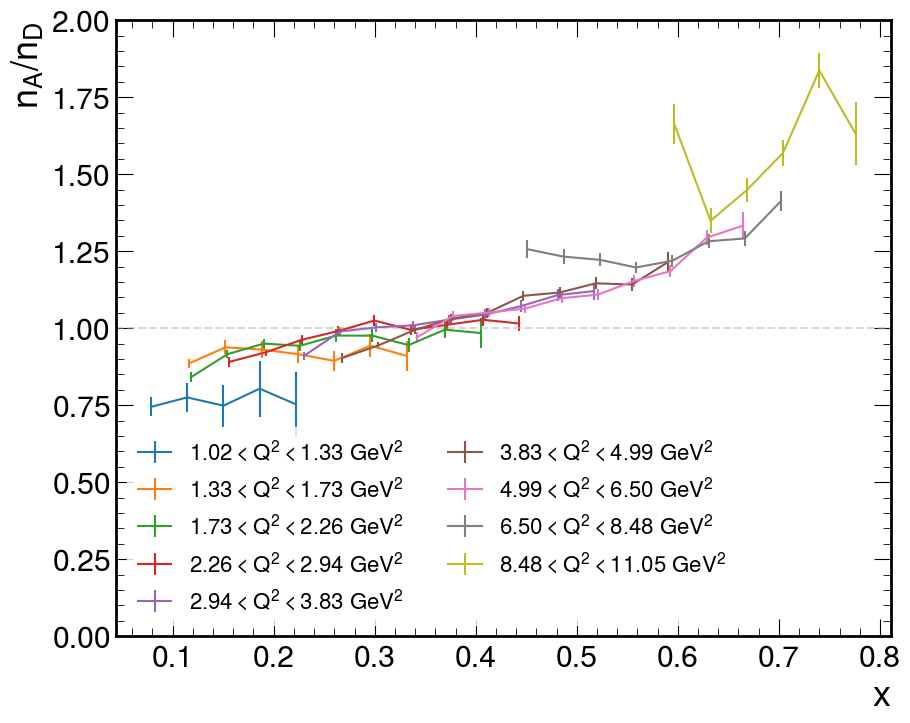

In [26]:
chi2=0
ndof=0

d={'x_low':[],'x_high':[], 'Q2_low':[],'Q2_high':[], 'R':[], 'dR':[]}
acceptances_A=[]
acceptances_D=[]

AC=np.zeros((len(xbins)-1, len(Q2bins)-1))
dAC=np.zeros((len(xbins)-1, len(Q2bins)-1))

for i in range(len(Q2bins)-1):
    ys, dys, bcs=[],[],[]
    for j in range(len(xbins)-1):
        if not include_bin[(j,i)]:
            continue
        q=f"Q2>{Q2bins[i]} and Q2<{Q2bins[i+1]} and x_bjorken>{xbins[j]} and x_bjorken<{xbins[j+1]}"
        q+="and W2>2**2 and y_bjorken<0.85"
        q+="and pid==11 and trigger_status==1"
        q+= " and " + vertex_cuts
        #q+= " and "+fid_cuts+ " and " +vertex_cuts + " and " + kin_cuts
        y,dy,accA,accD=get_acceptance_ratio(q)
        acceptances_A.append(accA)
        acceptances_D.append(accD)
        if (j,i) in Ngen:
            print(accA/Ngen[(j,i)],accD/Ngen[(j,i)])
        if accA<100 or accD<100:
            print("unused bin:", j,i)
            continue
        ys.append(y)
        dys.append(dy)
        bcs.append((xbins[j]+xbins[j+1])/2.+.002*i)
        
        AC[j][i]=1/y
        dAC[j][i]=dy/y**2
        
        d['Q2_low'].append(Q2bins[i])
        d['Q2_high'].append(Q2bins[i+1])
        d['x_low'].append(xbins[j])
        d['x_high'].append(xbins[j+1])
        d['R'].append(y)
        d['dR'].append(dy)
        
    plt.errorbar(bcs, ys,dys, label=f"${Q2bins[i]:.2f}<Q^2<{Q2bins[i+1]:.2f}$ GeV$^2$")
    ys=np.array(ys)
    dys=np.array(dys)

plt.xlabel("$x$")
plt.ylabel("$n_A/n_D$")
plt.axhline(1, ls='--',alpha=0.5, color='0.7')
plt.legend(fontsize=16, ncol=2)
df=pd.DataFrame(d)
plt.ylim(0, 2)

(0.0, 2.0)

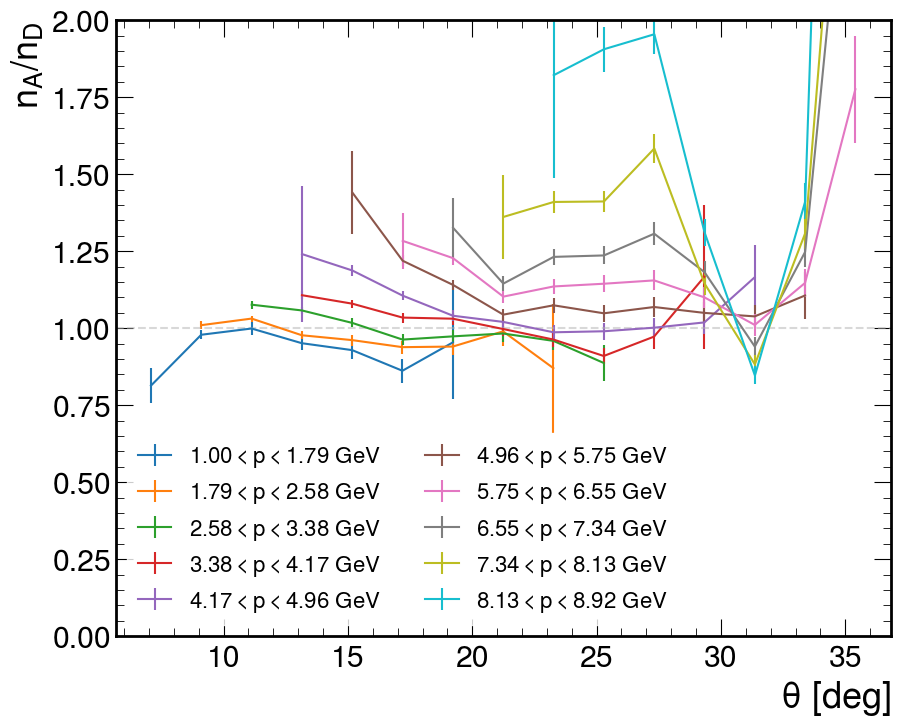

In [377]:
theta_bins=np.linspace(0, 180, 90)
p_bins=np.linspace(1, 10.5*0.85, 11)

# d={'x_low':[],'x_high':[], 'Q2_low':[],'Q2_high':[], 'R':[], 'dR':[]}
# acceptances_A=[]
# acceptances_D=[]
for i in range(len(p_bins)-1):
    ys, dys, bcs=[],[],[]
    for j in range(len(theta_bins)-1):
        #if not include_bin[(j,i)]:
        #    continue
        q=f"Q2>{p_bins[i]} and Q2<{p_bins[i+1]} and theta>{theta_bins[j]*np.pi/180} and theta<{theta_bins[j+1]*np.pi/180}"
        q+="and W2>2**2 and y_bjorken<0.85"
        q+="and pid==11 and trigger_status==1"
        q+= " and "+fid_cuts
        y,dy,accA,accD=get_acceptance_ratio(q)
#         acceptances_A.append(accA)
#         acceptances_D.append(accD)
        if accA<50 or accD<50:
            #print("unused bin:", j,i)
            continue
        ys.append(y)
        dys.append(dy)
        bcs.append((theta_bins[j]+theta_bins[j+1])/2.+.002*i)
        
#         d['Q2_low'].append(Q2bins[i])
#         d['Q2_high'].append(Q2bins[i+1])
#         d['x_low'].append(xbins[j])
#         d['x_high'].append(xbins[j+1])
#         d['R'].append(y)
#         d['dR'].append(dy)
        
    plt.errorbar(bcs, ys,dys, label=f"${p_bins[i]:.2f}<p<{p_bins[i+1]:.2f}$ GeV")
    ys=np.array(ys)
    dys=np.array(dys)

plt.xlabel("$\\theta$ [deg]")
plt.ylabel("$n_A/n_D$")
plt.axhline(1, ls='--',alpha=0.5, color='0.7')
plt.legend(fontsize=16, ncol=2)
# df=pd.DataFrame(d)
plt.ylim(0, 2)

(array([17.,  1.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,  3.,  0.,  1.,
         1.,  2.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  2.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
         1.,  1.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,  1.,  0.,  0.,  0.,
         1.,  1.,  2.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([   0.  ,   93.12,  186.24,  279.36,  372.48,  465.6 ,  558.72,
         651.84,  744.96,  838.08,  931.2 , 1024.32, 1117.44, 1210.56,
        1303.68, 1396.8 , 1489.92, 1583.04, 1676.16, 1769.28, 1862.4 ,
        1955.52, 2048.64, 2141.76, 2234.88, 2328.  , 2421.12, 2514.24,
        2607.36, 2700.48, 2793.6 , 2886.72, 2979.84, 3072.96, 3166.08,
        3259.2 , 3352.32, 3445.44, 3538.56, 3631.68, 3724.8 , 3817.92,
        

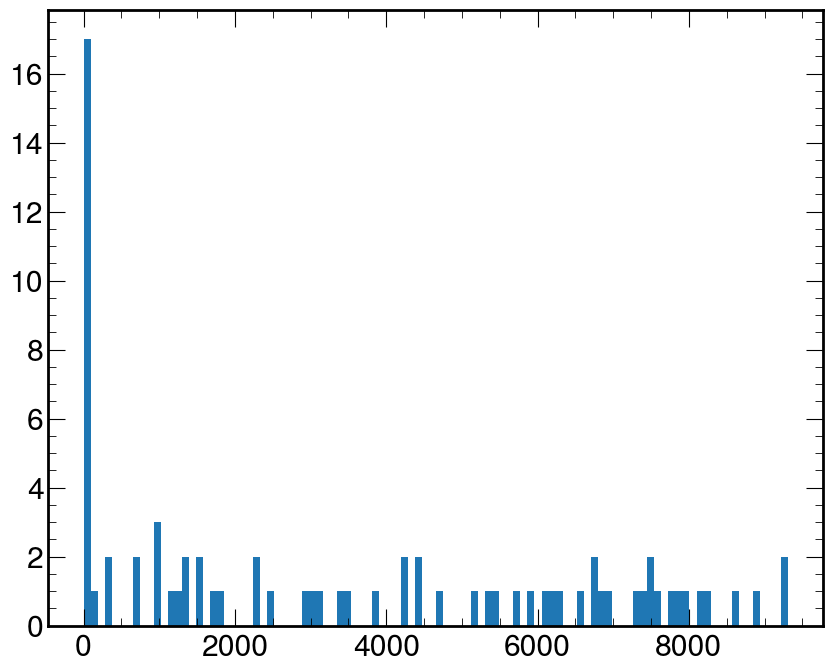

In [337]:
plt.hist(acceptances_D, bins=100)

In [330]:
print(df.to_csv())

,x_low,x_high,Q2_low,Q2_high,R,dR
0,0.09646465,0.13232323,1.32860611,1.73128997,0.8717568569310601,0.03477894690635463
1,0.16818182,0.2040404,1.32860611,1.73128997,0.9303571428571429,0.04004374344882161
2,0.2040404,0.23989899,1.32860611,1.73128997,1.028894472361809,0.051210452416539445
3,0.23989899,0.27575758,1.32860611,1.73128997,0.9574861367837338,0.05885955336245176
4,0.27575758,0.31161616,1.32860611,1.73128997,0.9471153846153846,0.06658104763958685
5,0.09646465,0.13232323,1.73128997,2.25602227,0.9478851963746223,0.03734354615575485
6,0.13232323,0.16818182,1.73128997,2.25602227,0.9451048484039001,0.015669588341176988
7,0.16818182,0.2040404,1.73128997,2.25602227,0.9579754601226994,0.0169612172300923
8,0.2040404,0.23989899,1.73128997,2.25602227,0.9517697394010113,0.019007027381867894
9,0.23989899,0.27575758,1.73128997,2.25602227,0.9753115447919116,0.021283438465776027
10,0.27575758,0.31161616,1.73128997,2.25602227,1.0025495750708215,0.023848288347280696
11,0.31161616,0.34747475,1.7312

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 array([ 1.  ,  1.11,  1.22,  1.33,  1.44,  1.55,  1.66,  1.77,

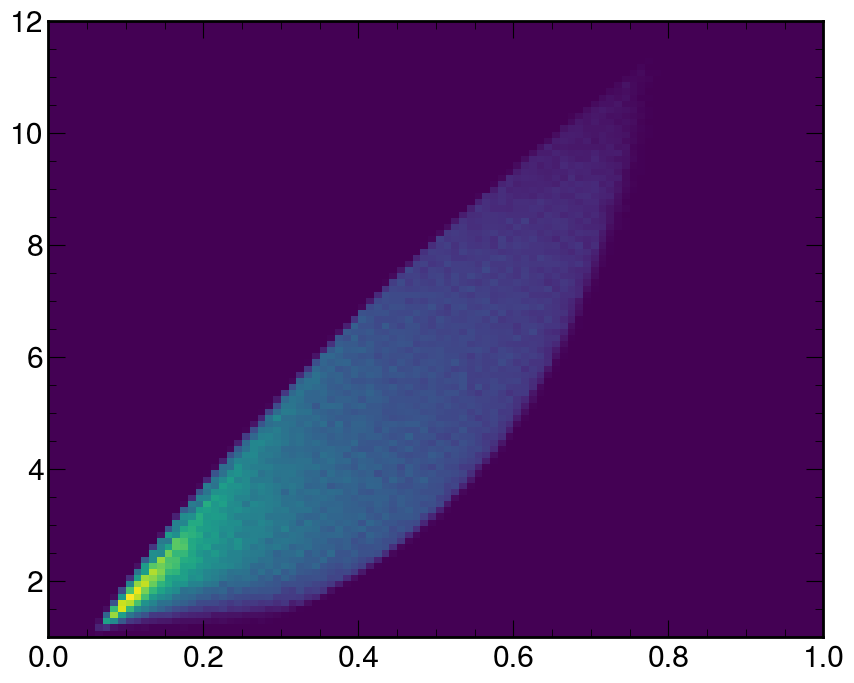

In [331]:
dfs['A'].columns
plt.hist2d(dfs['A'].x_bjorken, dfs['A'].Q2, bins=100, range=((0,1), (1, 12)))

In [149]:
##2*E*M*ymax*x==(Wmin**2-M**2)/(1/x-1)

In [150]:
# 1/xmin-1==(Wmin**2-M**2)/Q2min
# xmin= 1/((Wmin**2-M**2)/Q2min+1)

In [127]:
dfs['A'].columns

Index(['run_num', 'event_num', 'E_beam', 'pid', 'charge', 'status', 'mass',
       'v_x', 'v_y', 'v_z', 'p_x', 'p_y', 'p_z', 'p', 'theta', 'phi', 'beta',
       'trigger_status', 'sector', 'chi2', 'NDF', 'E_PCAL', 'E_ECIN', 'E_ECOU',
       'E_total', 'Delta_TOF', 'Nphe_LTCC', 'Nphe_HTCC', 'Q2', 'nu',
       'x_bjorken', 'y_bjorken', 'W2', 'z_h', 'p_T2', 'p_L2', 'phi_PQ',
       'theta_PQ'],
      dtype='object')

In [152]:
10.5**2*np.sin(5*np.pi/180/2)**2

0.20976726769252754

In [27]:
print(AC)
print(dAC)

[[1.34372911 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.29026439 1.1291229  1.18903667 0.         0.         0.
  0.         0.         0.        ]
 [1.33652547 1.06654786 1.09230299 1.12293359 0.         0.
  0.         0.         0.        ]
 [1.24478374 1.07500589 1.05301762 1.08521802 0.         0.
  0.         0.         0.        ]
 [1.32869524 1.0921772  1.06090273 1.03929059 1.0990179  0.
  0.         0.         0.        ]
 [0.         1.11897335 1.02480291 1.00961998 1.0112225  1.10768379
  0.         0.         0.        ]
 [0.         1.06037401 1.02517006 0.97602318 0.99752686 1.05932185
  0.         0.         0.        ]
 [0.         1.09911995 1.05838411 1.00574414 0.99112112 1.00614389
  1.0313279  0.         0.        ]
 [0.         0.         1.00512857 0.98940947 0.97353836 0.97082377
  0.9622066  0.         0.        ]
 [0.         0.         1.01636363 0.97362715 0.95801716 0.95288783
  0.95181222 0.         0.        ]
